<a href="https://colab.research.google.com/github/rachit2005/UNET-/blob/main/U_Net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms.functional as TF

In [ ]:
'''
It consists of a contracting path (left side) and an expansive path (right side).
The contracting path (encoder) follows architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling.

expansive path (decoder) consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.
'''

'''
It consists of a contracting path (left side) and an expansive path (right side).
The contracting path (encoder) follows architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling.

expansive path (decoder) consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.
'''

class Unet(nn.Module):
  def __init__(self, in_channels = 3 , out_channels = 1) -> None:
    super(Unet , self).__init__()

    # contracting path
    self.enc1 = self.conv_block(in_channels , 64)
    self.enc2 = self.conv_block(64 , 128)
    self.enc3 = self.conv_block(128 , 256)
    self.enc4 = self.conv_block(256 , 512)
    self.pool = nn.MaxPool2d(kernel_size=2 , stride=2)

    # bottle - neck part
    self.bottleneck = self.conv_block(512 , 1024)

    # expansive path
    self.upconv4 = nn.ConvTranspose2d(in_channels=1024 , out_channels=512 , kernel_size=2 , stride=2)
    self.dec4 = self.conv_block(1024 , 512)

    self.upconv3 = nn.ConvTranspose2d(in_channels=512 , out_channels=256 , kernel_size=2 , stride=2)
    self.dec3 = self.conv_block(512 , 256)

    self.upconv2 = nn.ConvTranspose2d(in_channels=256 , out_channels=128 , kernel_size=2 , stride=2)
    self.dec2 = self.conv_block(256 , 128)

    self.upconv1 = nn.ConvTranspose2d(in_channels=128 , out_channels=64 , kernel_size=2 , stride=2)
    self.dec1 = self.conv_block(128 , 64)

    self.final_layer = nn.Conv2d(in_channels=64 , out_channels=out_channels , kernel_size=1)


  def conv_block(self , in_channels , out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=3 , stride=1 , padding=1 , bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=out_channels , out_channels=out_channels , kernel_size=3 , stride=1 , padding= 1 , bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
    )

  def crop(self , enc , dec):
    # Use torchvision's center_crop to ensure exact size match
    return TF.center_crop(enc , dec.shape[2:])

  def forward(self , X):
    # contracting path
    enc1 = self.enc1(X)
    enc2 = self.enc2(self.pool(enc1))
    enc3 = self.enc3(self.pool(enc2))
    enc4 = self.enc4(self.pool(enc3))

    # bottel-neck
    bottle_neck = self.bottleneck(self.pool(enc4))

    # expansive path
    dec4 = self.upconv4(bottle_neck)
    dec4 = self.dec4(
        torch.cat((dec4 , self.crop(enc4 , dec4)) , dim=1))

    dec3 = self.upconv3(dec4)
    dec3 = self.dec3(
        torch.cat((dec3 , self.crop(enc3 , dec3)) , dim=1)
    )

    dec2 = self.upconv2(dec3)
    dec2 = self.dec2(
        torch.cat((dec2 , self.crop(enc2 , dec2)) , dim=1)
    )

    dec1 = self.upconv1(dec2)
    dec1 = self.dec1(
        torch.cat((dec1 , self.crop(enc1 , dec1)) , dim=1)
    )

    return self.final_layer(dec1)



# Using image segmentation model (U-Net) for pet  dataset

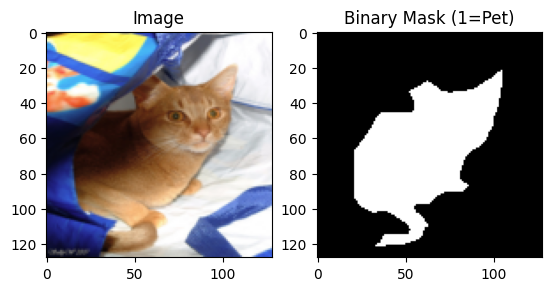

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class PetDataset(Dataset):
    def __init__(self, root, train=True):
        self.dataset = OxfordIIITPet(
            root=root,
            split='trainval' if train else 'test',
            target_types='segmentation',
            download=True
        )
        self.img_transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor(),
        ])

        self.mask_transform = T.Compose([
            T.Resize((128, 128), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = self.img_transform(img)

        mask = self.mask_transform(mask)
        mask = np.array(mask)

        # Fix mask: Pet = 1, background = 0, ignore undefined (0)
        mask = (mask == 1).astype(np.float32)  # Binary mask: 1=pet, 0=background
        mask = torch.tensor(mask).unsqueeze(0)  # shape: [1, H, W]

        return img, mask

dataset = PetDataset(root="./data", train=True)
img, mask = dataset[0]

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Binary Mask (1=Pet)")
plt.show()

In [ ]:
unet = Unet(3,1)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters() , lr=0.001)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

len(dataset) , device

(3680, device(type='cuda'))

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    unet.train()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = unet(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(loader):.4f}")


Epoch [1/5], Loss: 0.4558
Epoch [2/5], Loss: 0.3594
Epoch [3/5], Loss: 0.3132
Epoch [4/5], Loss: 0.2887
Epoch [5/5], Loss: 0.2572


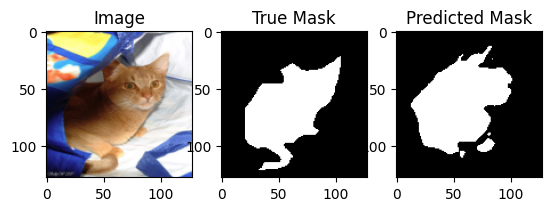

In [ ]:
unet.eval()
with torch.no_grad():
    img, true_mask = dataset[0]
    img = img.unsqueeze(0).to(device)
    pred_mask = unet(img)
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = (pred_mask > 0.5).float()

import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze().cpu(), cmap='gray')
plt.title('Predicted Mask')
plt.show()


# Using U-Net model for retina Blood Vessel

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"rachitsdfdsfsdfs","key":"8c0550912c2c472e219c47752600eb25"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download datasetn

!kaggle datasets download -d abdallahwagih/retina-blood-vessel

# Unzip
!unzip -q retina-blood-vessel.zip -d retina-blood-vessel


Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
retina-blood-vessel.zip: Skipping, found more recently modified local copy (use --force to force download)
replace retina-blood-vessel/Data/test/image/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace retina-blood-vessel/Data/test/image/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/11.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/12.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/13.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/14.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/15.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace retina-blood-vessel/Data/test/image/16.png? [y]es

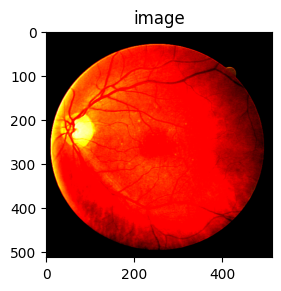

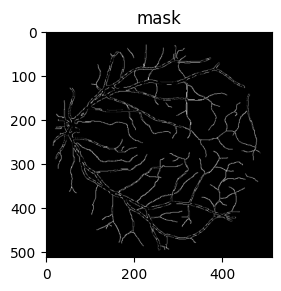

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class Dataset_By_me(Dataset):
  def __init__(self , image_dir , mask_dir , transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = sorted(os.listdir(image_dir))
    self.masks = sorted(os.listdir(mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self , index):
    img_path = os.path.join(self.image_dir , self.images[index])
    mask_path = os.path.join(self.mask_dir , self.masks[index])

    image = np.array(Image.open(img_path).convert('RGB'))
    mask = np.array(Image.open(mask_path).convert('L') , dtype=np.float32)

    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image , mask=mask)
      image = augmentations['image']
      mask = augmentations['mask']

    return image , mask.unsqueeze(0)

train_img_dir = 'retina-blood-vessel/Data/train/image'
train_mask_dir = 'retina-blood-vessel/Data/train/mask'
test_img_dir = 'retina-blood-vessel/Data/test/image'
test_mask_dir = 'retina-blood-vessel/Data/test/mask'

transformation = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225) , max_pixel_value=255), # Example normalization for RGB images
    ToTensorV2(), # Converts image to PyTorch tensor and moves channel dimension to the front
])

train_dataset = Dataset_By_me(train_img_dir , train_mask_dir , transform=transformation)
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)

test_dataset = Dataset_By_me(test_img_dir , test_mask_dir , transformation)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=True)

img , mask = train_dataset[0]

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('image')
plt.show()

plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0) , cmap='gray')
plt.title('mask')
plt.show()

print(img.shape , mask.shape)

In [ ]:
train_dataloader = DataLoader(train_dataset , batch_size=16 , shuffle=True)
test_dataloader = DataLoader(test_dataset , batch_size=16 , shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(3,1)
model.to(device)

device

device(type='cuda')

In [ ]:
# Hyperparameters -->
lr = 1e-4
num_epochs = 10

import torch
torch.cuda.empty_cache()


def train_model(model:nn.Module , dataloader:DataLoader , loss_fn:nn.Module , optimizer:torch.optim.Optimizer , scaler):
  model.train()
  for batch_idx , (data ,target) in enumerate(dataloader):
    print(batch_idx)
    data = data.to(device)
    target = target.float().to(device)
    # print(data.shape , target.shape)

    # forward pass
    pred = model(data)
    loss = loss_fn(pred , target)

    # backward pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    optimizer.step()
    scaler.update()


loss_fn = nn.BCEWithLogitsLoss()
model = Unet(3,1).to(device)
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters() , lr=lr)

train_model(model , train_dataloader , loss_fn , optimizer , scaler)

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import torch
torch.cuda.empty_cache()


torch.cuda.empty_cache()

# Fix 1: Dice Score with safe flattening
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = Unet(3, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 50
losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        dice = dice_score(model(images), masks)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Dice Score: {dice:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 34145 has 14.73 GiB memory in use. Of the allocated memory 13.77 GiB is allocated by PyTorch, and 863.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model.eval()
dice_total = 0.0
with torch.no_grad():
    for imgs, masks in test_dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        dice_total += dice_score(outputs, masks)

avg_dice = dice_total / len(test_dataloader)
print(f"Average Dice Score on Test Set: {avg_dice:.4f}")


In [ ]:
torch.cuda.empty_cache()

model.eval()
with torch.no_grad():
  for idx in range(3):
    img , mask = test_dataset[idx]
    img = img.unsqueeze(0).to(device)

    output = model(img)
    print(output.squeeze().cpu()) # Print the raw model output
    output = torch.sigmoid(output)
    print(output.squeeze().cpu()) # Print the sigmoid output

    output = (output > 0.5).float()
    print(torch.unique(output.squeeze().cpu())) # comming only [0.]

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().permute(1,2,0).cpu())
    plt.title('Image')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1,3,3)
    plt.imshow(output.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

In [ ]:
def binary_accuracy(preds, targets, threshold=0.5):
    """
    Compute accuracy for binary segmentation.
    preds: raw model output before sigmoid
    targets: ground truth mask (0 and 1)
    """
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.sum() / correct.numel()

model.eval()
with torch.no_grad():
    for img, mask in test_dataloader:
        img = img.to(device)
        mask = mask.unsqueeze(1).to(device)
        output = model(img)
        acc = binary_accuracy(output, mask)
        print(f"Accuracy: {acc.item():.4f}")
        print(output.shape)
        print(mask.shape)
        break


In [ ]:
model.eval()
with torch.no_grad():
  for idx in range(3):
    img , mask = test_dataset[idx]
    img = img.unsqueeze(0).to(device)
    mask = mask.to(device)

    output = model(img)
    output = torch.sigmoid(output)
    output = (output > 0.5).float()

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().permute(1,2,0).cpu())
    plt.title('Image')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1,3,3)
    plt.imshow(output.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()
